## Adding new emission data: local

Once you have a **DELWAQ** model, you may want to update your model in order to add new emission data, add sample locations, use different hydrological forcing data, create and run different scenarios etc.

With HydroMT, you can easily read your model and update one or several components of your model using the **update** function of the command line interface (CLI). Here are the steps and some examples on how to **update and add local emission data to your model**.

All lines in this notebook which starts with ! are executed from the command line. Within the notebook environment the logging messages are shown after completion. You can also copy these lines and paste them in your shell to get more feedback.

### Import packages

In this notebook, we will use some functions of HydroMT to prepare hydroMT configuration and library file and plot the new emission data of the updated model. Here are the libraries to import to realize these steps.

In [1]:
import numpy as np
import geopandas as gpd

In [2]:
# for plotting
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
proj = ccrs.PlateCarree() # plot projection

In [3]:
# import hydromt
import hydromt

In [4]:
# setup logging
from  hydromt.log import setuplog
logger = setuplog("update_model_emission_local", log_level=10)

2021-05-06 12:12:54,351 - update_model_emission_local - log - INFO - HydroMT version: 0.4.0


### hydroMT CLI update interface

Using the `hydroMT update` API, we can update one or several components of an already existing DELWAQ model. Let's get an overview of the available options:

In [5]:
# Print the options available from the update command
! hydromt update --help

Usage: hydromt update [OPTIONS] MODEL MODEL_ROOT

  Update a specific component of a model. Set an output directory to copy
  the edited model to a new folder, otherwise maps are overwritten.

  Example usage:
  --------------

  Update (overwrite) landuse-landcover maps in a wflow model
  hydromt update wflow /path/to/model_root -c setup_lulcmaps --opt source_name=vito

  Update reservoir maps based on default settings in a wflow model and write to new directory
  hydromt update wflow /path/to/model_root -o /path/to/model_out -c setup_reservoirs

Options:
  -o, --model-out DIRECTORY  Output model folder. Maps in MODEL_ROOT are
                             overwritten if left empty.

  -c, --components TEXT      Model components from ini file to run
  --opt TEXT                 Component specific keyword arguments, see the
                             setup_<component> method of the specific model
                             for more information about the arguments.

  -i, --config PA

### Adding local data to the model

Using HydroMT, it is rather easy to add additional emission data using local data. Here we will see an example where we **add a emission factor map** from a local (dummy!) source stored in *examples_data/emission_factor.gpkg*.

Compared to global data, that can be added directly to a delwaq model, we first need to **add our local data the the HydroMT Data Catalog** using a local yaml data library. The full steps and infomation to add data the HydroMT data library is available in the [docs](https://deltares.github.io/hydromt/latest/user_guide/data.html).

Here we will see the steps for our (dummy) emission factor source. And first see what the data looks like (you can also download and open it in QGIS instead of loading it with python).

In [6]:
#Let's read and quickly plot the data
emission_data = 'examples_data/emission_factor.gpkg'
#Open with geopandas and plot
gdf = gpd.read_file(emission_data)
#Content
print("Content of the local emission_factor.gpkg file: ")
gdf

Content of the local emission_factor.gpkg file: 


,OBJECTID,ISO_3DIGIT,NAME,EF,geometry
0,19,AUT,Austria,1.500,"MULTIPOLYGON (((15.01626 49.01902, 15.03378 49..."
1,22,BEL,Belgium,2.260,"MULTIPOLYGON (((4.94299 51.44159, 4.94078 51.4..."
2,47,CHE,Switzerland,1.710,"MULTIPOLYGON (((8.57693 47.81010, 8.59278 47.8..."
3,65,DEU,Germany,1.390,"MULTIPOLYGON (((8.70214 47.71345, 8.71030 47.7..."
4,82,FRA,France,2.175,"MULTIPOLYGON (((9.25835 41.34536, 9.25813 41.3..."
5,135,LIE,Liechtenstein,1.605,"MULTIPOLYGON (((9.56471 47.17015, 9.57504 47.1..."
6,139,LUX,Luxembourg,2.260,"MULTIPOLYGON (((6.02926 50.17731, 6.03060 50.1..."
7,171,NLD,Netherlands,1.410,"MULTIPOLYGON (((3.51562 51.40709, 3.54988 51.4..."
8,117,ITA,Italy,2.175,"MULTIPOLYGON (((12.53929 35.52953, 12.54022 35..."


Coordinate system of the data: epsg:4326


<AxesSubplot:>

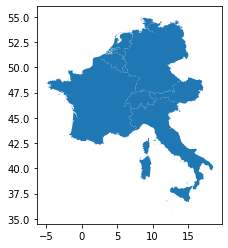

In [7]:
#coordinate system
print(f"Coordinate system of the data: {gdf.crs}")
#Quick plot
gdf.plot()

We can see that our data is a **vector file** with some European countries in EPSG **4326**, and that it contains our emission factors in the **EF** column. We now have information enough to add it to the HydroMT data sources by preparing a **local_emission_sources.yml**.

In [8]:
# Dictionary with all the required information on our emission_factor.gpkg file
data_dict = {
    'EF_local': {                      # user defined internal name of the local data source
        'path': 'examples_data/emission_factor.gpkg', # path to the local data
        'data_type': 'GeoDataFrame',   # hydroMT DataCatalog type 'GeoDataFrame' for vector file
        'driver': 'vector',            # driver to read the file 'vector' for vector file
        'crs': 4326,                   # optional here but mentioned as en example
        'rename': {
            'NAME': 'COUNTRY',         # dummy here but can be used to rename some of the data columns 
        },
        'unit_mult': {
            'EF': 1.0,                 # dummy here (EF*1.0) but can be used to convert units (should be kg/d/EV)
        },
        'unit_add':{
            'EF': 0.0,                 # dummy here (EF+0.0) but can be used to convert units (should be kg/d/EV)
        },
        'meta': {                      # additional information on the file (license, download link, DOI, author...)
            'category': 'socio econpmic',
            'source_url': 'https://github.com/Deltares/hydromt_delwaq/tree/main/examples/examples_data/emission_factor.gpkg',
            'notes': 'Dummy emission factor data',
        },
    },
}

# Convert the dict to hydroMT yaml library format and save the file
fn_yml = 'local_emission_sources.yml'
data_catalog = hydromt.DataCatalog(logger=logger)
data_catalog.from_dict(data_dict)
data_catalog.to_yml(fn_yml)

#Read the saved yml
with open(fn_yml, 'r') as f:
    txt = f.read()
print(txt)

EF_local:
  crs: 4326
  data_type: GeoDataFrame
  driver: vector
  meta:
    category: socio econpmic
    notes: Dummy emission factor data
    source_url: https://github.com/Deltares/hydromt_delwaq/tree/main/examples/examples_data/emission_factor.gpkg
  path: examples_data/emission_factor.gpkg
  rename:
    NAME: COUNTRY
  unit_add:
    EF: 0.0
  unit_mult:
    EF: 1.0



Our local data is now ready to be processed by HydroMT !

### Preparing the configuration file

As our new **EF_local** data is a **vector** data, we will add it to our model using the `[setup_emission_vector]` component of hydroMT Delwaq.

Let's prepare a **HydroMT configuration file** with our options for preparing the EF_local grid. All available options are available in the [docs(setup_emission_vector)](https://deltares.github.io/hydromt_delwaq/latest/generated/hydromt_delwaq.delwaq.DelwaqModel.setup_emission_vector.html).

In [9]:
# Dictionnary with all the components and options we want to update
emission_vector_options = {
    'global' : {'mtype': 'EM'},
    'setup_emission_vector': {
        'emission_fn': 'EF_local',
        'col2raster': 'EF',
        'rasterize_method': 'value',
    },
}

# Save it to a hydroMT ini file
fn_ini = "delwaq_update_emission_local.ini"
hydromt.config.configwrite(fn_ini, emission_vector_options)

# Open the file and visualize the content
with open(fn_ini, 'r') as f:
    txt = f.read()
print(txt)

[global]
mtype = EM

[setup_emission_vector]
emission_fn = EF_local
col2raster = EF
rasterize_method = value




Some explanations about the option we chose here:

* **emission_fn**: name of the emission factor data source in hydroMT Data Catalog. The one we choose when creating the *local_emission_sources.yml*.
* **col2raster**: name of the column in the vector file that contains the emission factors values to rasterize to the model grid.
* **rasterize_method**: method to rasterize the vector either *value* to rasterize the values in the 'col2raster' column, or *fraction* to rasterize the fraction of the model grid cell that is covered by the vector shapes (eg fraction of agricultural areas).

### Updating the model with the local data

In [10]:
# NOTE: copy this line (without !) to your shell for more direct feedback
! hydromt update delwaq EM_piave -o ./EM_piave_extended -i delwaq_update_emission_local.ini -d local_emission_sources.yml -vv

2021-05-06 12:13:01,802 - update - log - DEBUG - Appending log messages to file /home/runner/work/hydromt_delwaq/hydromt_delwaq/docs/examples/examples/EM_piave_extended/hydromt.log.
2021-05-06 12:13:01,803 - update - log - INFO - HydroMT version: 0.4.0
2021-05-06 12:13:01,803 - update - main - INFO - Updating delwaq model at /home/runner/work/hydromt_delwaq/hydromt_delwaq/docs/examples/examples/EM_piave (r).
2021-05-06 12:13:01,803 - update - main - INFO - Output dir: /home/runner/work/hydromt_delwaq/hydromt_delwaq/docs/examples/examples/EM_piave_extended
2021-05-06 12:13:01,803 - update - main - INFO - Additional data sources: ('/home/runner/work/hydromt_delwaq/hydromt_delwaq/docs/examples/examples/local_emission_sources.yml',)
2021-05-06 12:13:01,803 - update - main - INFO - User settings:
2021-05-06 12:13:01,804 - update - cli_utils - INFO - global.mtype: EM
2021-05-06 12:13:01,804 - update - cli_utils - INFO - setup_emission_vector.emission_fn: EF_local
2021-05-06 12:13:01,804 - up

2021-05-06 12:13:01,923 - update - delwaq - INFO - Read staticmaps from /home/runner/work/hydromt_delwaq/hydromt_delwaq/docs/examples/examples/EM_piave/staticdata/staticmaps.nc


2021-05-06 12:13:01,933 - update - delwaq - INFO - Model read
2021-05-06 12:13:01,933 - update - model_api - WARNING - Model dir already exists and files might be overwritten: /home/runner/work/hydromt_delwaq/hydromt_delwaq/docs/examples/examples/EM_piave_extended/hydromodel.
2021-05-06 12:13:01,933 - update - model_api - WARNING - Model dir already exists and files might be overwritten: /home/runner/work/hydromt_delwaq/hydromt_delwaq/docs/examples/examples/EM_piave_extended/staticdata.
2021-05-06 12:13:01,933 - update - model_api - WARNING - Model dir already exists and files might be overwritten: /home/runner/work/hydromt_delwaq/hydromt_delwaq/docs/examples/examples/EM_piave_extended/staticgeoms.
2021-05-06 12:13:01,933 - update - model_api - WARNING - Model dir already exists and files might be overwritten: /home/runner/work/hydromt_delwaq/hydromt_delwaq/docs/examples/examples/EM_piave_extended/config.
2021-05-06 12:13:01,934 - update - model_api - WARNING - Model dir already exists

2021-05-06 12:13:02,114 - update - data_adapter - DEBUG - GeoDataFrame: Convert units for 2 columns.


2021-05-06 12:13:02,206 - update - delwaq - INFO - Write model data to /home/runner/work/hydromt_delwaq/hydromt_delwaq/docs/examples/examples/EM_piave_extended
2021-05-06 12:13:02,225 - update - delwaq - INFO - Writing staticmap files.


2021-05-06 12:13:02,240 - update - delwaq - INFO - Writing model staticgeom to file.
2021-05-06 12:13:02,260 - update - delwaq - INFO - Writing hydromap files.


2021-05-06 12:13:02,351 - update - delwaq - WARNING - Warning: no dynamic map, skipping write_dynamicmaps.


The example above means the following: run **hydromt** with:

- `update delwaq`: i.e. update a delwaq model
- `EM_piave`: original model folder
- `-o ./EM_piave_extended`: output updated model folder
- `-i delwaq_update_emission_local.ini`: hydroMT configuration file containing the components and options to update
- `-d local_emission_sources.yml`: hydroMT local data library file containing local data sources and their attributes.
- `-v`: give some extra verbosity (2 * v) to display feedback on screen. Now debug messages are provided.

### Visualization of the new emission map

We can now plot our newly created emission factor map.

In [11]:
# Load the original and updated model with hydromt
mod = hydromt.DelwaqModel(root='EM_piave_extended', mode='r')

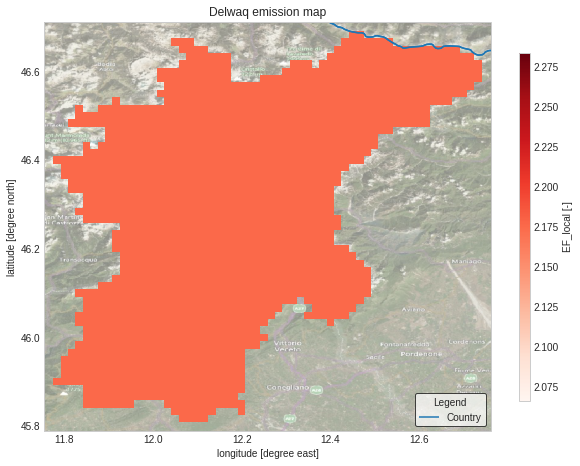

In [12]:
# Edit the lines below to change the emission map and its colormap
emissionmap = 'EF_local'
colormap = 'Reds'

#Load the emission map
da = mod.staticmaps[emissionmap].raster.mask_nodata()
da.attrs.update(long_name=emissionmap, units='-')

#Plot
plt.style.use('seaborn-whitegrid') # set nice style
# we assume the model maps are in the geographic CRS EPSG:4326
proj = ccrs.PlateCarree()
# adjust zoomlevel and figure size to your basis size & aspect
zoom_level = 10
figsize=(10, 8)

# initialize image with geoaxes
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection=proj)
extent = np.array(da.raster.box.buffer(0.02).total_bounds)[[0, 2, 1, 3]]
ax.set_extent(extent, crs=proj)

# add sat background image
ax.add_image(cimgt.QuadtreeTiles(), zoom_level, alpha=0.5)

# add the country shape
country_shape = 'examples_data/emission_factor.gpkg'
#Open with geopandas and plot
gdf = gpd.read_file(country_shape)
gdf.boundary.plot(transform=proj, ax=ax, label="Country")

## plot emission map
cmap = plt.cm.get_cmap(colormap)
kwargs = dict(cmap=cmap)
# plot 'normal' elevation
da.plot(transform=proj, ax=ax, zorder=1, cbar_kwargs=dict(aspect=30, shrink=.8), **kwargs)

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.set_ylabel(f"latitude [degree north]")
ax.set_xlabel(f"longitude [degree east]")
_ = ax.set_title(f"Delwaq emission map")
legend = ax.legend(
    handles=[*ax.get_legend_handles_labels()[0]],
    title="Legend",
    loc='lower right',
    frameon=True,
    framealpha=0.7,
    edgecolor='k',
    facecolor='white'
)

Our Delwaq model is completely located in Italy so our **EF_local** map here only has the same value for every grid cell.

If you are using Binder, feel free to edit this notebook to try out with your own local data (you need to first upload your data in Binder using the upload button).

Note that you can also download the models you created in Binder by first zipping them using the lines below and downloading the zipped model.

In [13]:
# Lines to zip a model folder
model_folder = 'EM_piave_extended'

#Zipping
import shutil
shutil.make_archive(model_folder, 'zip', model_folder)

'/home/runner/work/hydromt_delwaq/hydromt_delwaq/docs/examples/examples/EM_piave_extended.zip'